In [1]:
# Functions to save and load variables/data

def pickle_save(name, path, data, verbose=True):
    if not os.path.exists(path):
        os.makedirs(path)
    full_name = (os.path.join(path,name+ '.npy'))


    with open(full_name, 'wb') as f2:
        pickle.dump(data, f2)
    if verbose:
        print('saved at : ',full_name)

def pickle_load(name, path, verbose=True):
    #if not os.path.exists(path):
    #    os.makedirs(path)
    full_name= (os.path.join(path,name+ '.npy'))

    with open(full_name, 'r') as f:
        data=pickle.load(f)

    if verbose:
        print('loaded from : ',full_name)
    return data

In [2]:
def lambert_map(cbar_levels, X, Y, data, title, title_colorbar, cmap, path_save, title_save):
        '''
        Function for plotting a lambert projection map.
        
        Args : 
        cbar_levels, X, Y, data, title, title_colorbar, path_save, title_save
        '''
        import matplotlib.pyplot as plt
        import numpy as np
        from mpl_toolkits.basemap import Basemap
        
        v       = cbar_levels
        fig     = plt.figure(figsize=(8,8))
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm, ym  = m(X, Y)
        im      = m.contourf(xm, ym, data, levels=v, extend='both', cmap=cmap)

        cbar = m.colorbar(im,pad='10%')
        cbar.set_label(title_colorbar, fontsize =16)

        m.fillcontinents(color='0.5', lake_color='0.5')
        m.drawparallels(np.arange(-80.,-60.,5), labels=[1, 0, 0, 0])
        m.drawmeridians(np.arange(160.,210.,5), labels=[0, 0, 0, 1])
        m.drawcoastlines()
       
        m2      = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-68.,\
                  rsphere=(6378137.00,6356752.3142),\
                  resolution='l',area_thresh=1000.,projection='lcc',\
                  lat_1=65.,lon_0=180.)
        xm2, ym2  = m2(LON, LAT)
        im2     = m2.plot(xm2,ym2,'.', color='k',linewidth=2.)

        plt.title(title, fontsize=18)
        plt.savefig(path_save + title_save, bbox_inches='tight')

In [3]:
def investigate_traj(figsize, proj, nb_traj, hfacc_level):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.basemap import Basemap
    import cmocean
    
    fig     = plt.figure(figsize=figsize)
    
    if proj=='ortho':
        m       = Basemap(projection='ortho', lat_0=-90, lon_0=0, resolution="l")
    elif proj=='merc':
        m       = Basemap(projection='merc',llcrnrlat=-78.,urcrnrlat=-40.,llcrnrlon=120.,urcrnrlon=270.,lat_ts=-60.,resolution='c')
    elif proj=='lamb':
        m       = Basemap(llcrnrlon=162.,llcrnrlat=-79.,urcrnrlon=230.,urcrnrlat=-60.,rsphere=(6378137.00,6356752.3142),resolution='l',area_thresh=1000.,projection='lcc',lat_1=65.,lon_0=180.)
            
    # Plot the continents thanks to hFacC==0, choose the level : 0=surf, 9=30m
    xm, ym  = m(Xf, Yf)
    im      = m.contourf(xm, ym, hFacC[hfacc_level,...], extend='both', cmap='Greys_r')
    
    # Plot the salinity
    #xm, ym  = m(XC, YC)
    #im      = m.contourf(xm, ym, mean_Salt_30, levels=np.linspace(32.8,35.3,50), extend='both', cmap=cmocean.cm.haline)
    #cbar    = m.colorbar(im,pad='10%')
    #cbar.set_label('Salinity', fontsize =16)
    
    # Plot the stream function
    xm, ym  = m(XC, YC)
    cs      = m.contour(xm, ym, SF, extend='both', levels=np.linspace(np.nanmin(SF), np.nanmax(SF), 10), colors='k', linewidth=0.3)
    plt.clabel(cs, inline=True, fontsize=8)
    
    # Plot the southern front
    xm, ym  = m(XC, YC)
    im      = m.contour(xm, ym, southern_front)
    
    # Plot all the traj
    for p in nb_traj: 
        #xm, ym  = m(LON[:,p], LAT[:,p])
        #im      = m.plot(xm, ym, '-', color='orange',linewidth=0.4)
        xm, ym  = m(LON[0,p], LAT[0,p])
        im      = m.plot(xm, ym, '.', color='b',linewidth=2.)
        #xm, ym  = m(LON[-1,p], LAT[-1,p])
        #im      = m.plot(xm, ym, '*', color='r',linewidth=3.)
        
    # Plot the southern front
    xm, ym  = m(XC, YC)
    im      = m.contour(xm, ym, southern_front)
        
    m.drawparallels(np.arange(-80.,-30.,10), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(120.,280.,10), labels=[0, 0, 0, 1])
    #plt.title('10 000 parti, 5 years (hFacC and S at 30 m)', fontsize=18)
    #plt.savefig(path_save + title_save, bbox_inches='tight')

In [4]:
%matplotlib inline

# Import packages
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, pi
import h5py
from scipy.io import loadmat
from mpl_toolkits.basemap import Basemap
import netCDF4
from scipy import interpolate
import os
import pickle
import cmocean

plot_path_1993_2017='/home/ebent/plots/1993_2017/'
plot_path_2006_2011='/home/ebent/plots/2006_2011/'
plot_path_jup='/home/ebent/plots/2006_2011/jup2/'
load_path='/data/mmazloff/AVISO/'
load_path2='/data/SO12/runs/RUN_BLING_Dec2017/SO12_RUN/DIAGNOSTICS/'
load_path3='/data/soccom/GRID_12/'

In [5]:
# Mercator salinity
mean_Salt_surf = pickle_load('mean_Salt_surf_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_30     = pickle_load('mean_Salt_30_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_100   = pickle_load('mean_Salt_100_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_200   = pickle_load('mean_Salt_200_2', '/data/ebent/Bigger_domain/', verbose=False)
mean_Salt_500   = pickle_load('mean_Salt_500_2', '/data/ebent/Bigger_domain/', verbose=False)

# Mercator temperature
mean_Theta_surf = pickle_load('mean_Theta_surf_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_30     = pickle_load('mean_Theta_30_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_100   = pickle_load('mean_Theta_100_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_200   = pickle_load('mean_Theta_200_2', '/data/ebent/Bigger_domain', verbose=False)
mean_Theta_500   = pickle_load('mean_Theta_500_2', '/data/ebent/Bigger_domain', verbose=False)

In [6]:
SF = pickle_load('SF_2', '/data/ebent/', verbose=False)

In [7]:
# Load files
file1 = netCDF4.Dataset(load_path2+'so12_i0_year2006_5day_Salt.nc','r')

In [8]:
# This is hFacC for the SOUTHERN HEMISPHERE

file_h = h5py.File(load_path3 + 'grid.mat','r')

hFacC = file_h.get('hFacC')
hFacC = np.array(hFacC)
Xf = file_h.get('XC')
Xf = np.array(Xf)
Yf = file_h.get('YC')
Yf = np.array(Yf)

In [9]:
# On selectionne la bonne taille de hFacC == taille de "bigger domain"
lon_min   = 1440 
lon_max   = 3241
lat_min   = 0 
lat_max   = 1024

YC        = file1.variables['lat'][lat_min:lat_max] # de -77,99 a -40,05
XC        = file1.variables['lon'][lon_min:lon_max] # de 120,04 a 270,04
XC, YC    = np.meshgrid(XC, YC)

hfacc = hFacC[:, lat_min:lat_max, lon_min:lon_max]

In [10]:
southern_front = pickle_load('ACC_southern_front', '/data/ebent/', verbose=False)
southern_front = np.ma.masked_array(southern_front, mask=False)

In [11]:
W_boundary = 12 # 121,04 degrees
E_boundary = 1560 # 250,04 degrees

In [12]:
# Create a meshgrid to plot in index coordinates
xc = np.arange(1801)
yc = np.arange(1024)
xc, yc = np.meshgrid(xc,yc)

In [13]:
npts = 10000

***

# Load variables

In [14]:
path = '/data/ebent/Octopus/output/50m_line_RG/'

In [99]:
NPP = 'NPP01'

In [100]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/NPP01_xround.npy')


In [17]:
Z1 = pickle_load(NPP + '_Z1', path)
Z2 = pickle_load(NPP + '_Z2', path)
Z3 = pickle_load(NPP + '_Z3', path)
Z4 = pickle_load(NPP + '_Z4', path)
Z5 = pickle_load(NPP + '_Z5', path)
dead = pickle_load(NPP + '_dead', path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z1.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z2.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z3.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z4.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_Z5.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP01_dead.npy')


In [18]:
dead = dead-dead[0]

***

# Plots

In [95]:
path = '/data/ebent/Octopus/output/50m_line_RG/'

In [96]:
Ind_parti_north = pickle_load('Ind_parti_north', path)

('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/Ind_parti_north.npy')


In [97]:
import itertools
all_ind = []
npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

for NPP in npp:
    all_ind.append(Ind_parti_north[NPP])
    
ind_parti_north = list(itertools.chain(*all_ind))

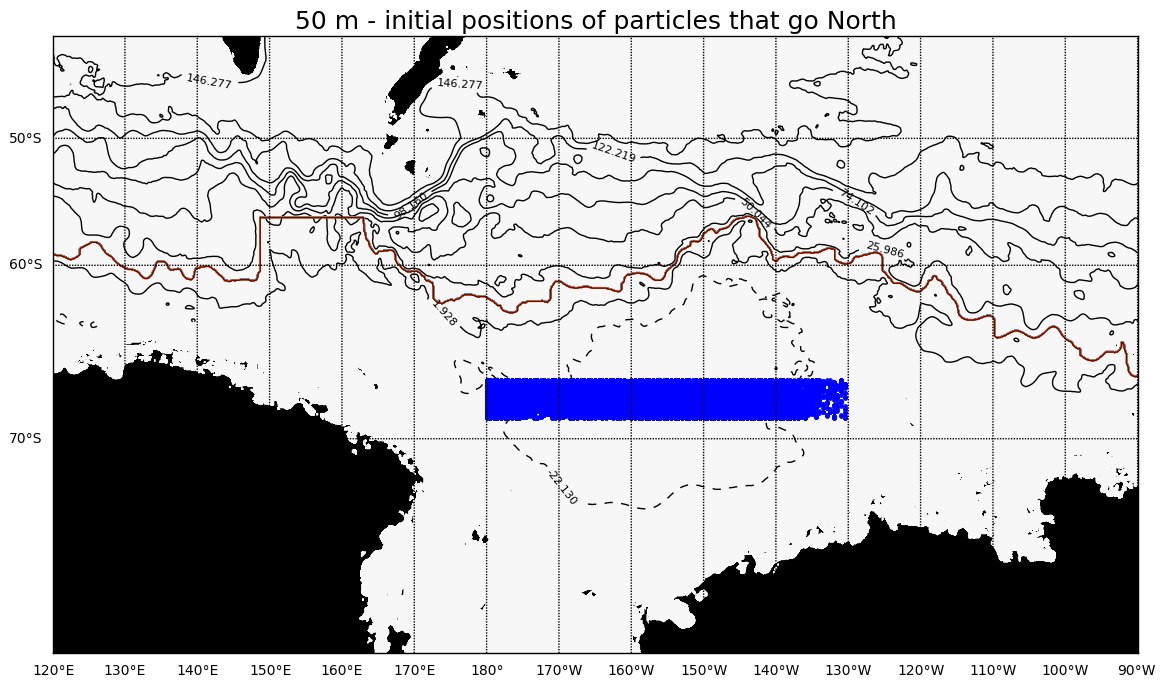

In [114]:
# Initial pos of particles that go north
investigate_traj(figsize=(14,10), proj='merc', nb_traj=ind_parti_north, hfacc_level=44)
plt.title('50 m - initial positions of particles that go North', fontsize=18)

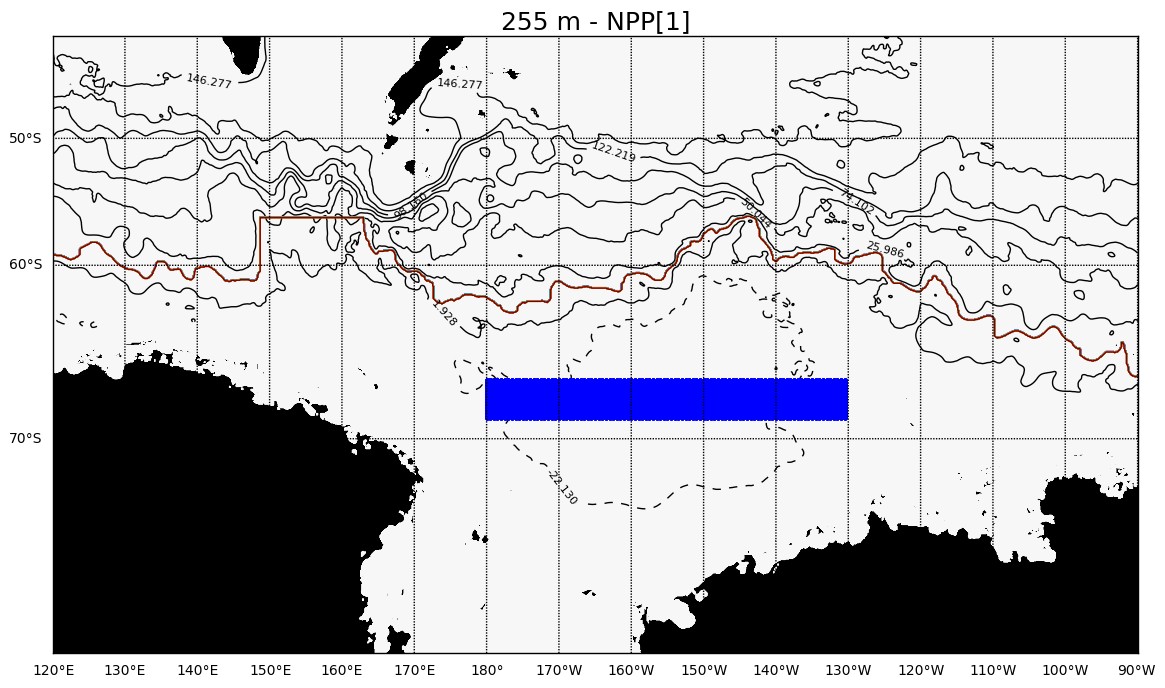

In [260]:
# Initial positions of all particles
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(10000), hfacc_level=44)
plt.title('50 m - initial pos', fontsize=18)

***

# Plot of the traj of the experiment 

In [115]:
XC, YC    = np.meshgrid(XC, YC)

MemoryError: 

Plot of all the parti

In [ ]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(3000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

In [ ]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(3000,6000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

In [ ]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(6000,8000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

In [ ]:
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(8000,10000), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

In [ ]:
# Particle that goes east and passes north at one point
investigate_traj(figsize=(14,10), proj='merc', nb_traj=range(7798, 7799), hfacc_level=65)
plt.title('725 m - NPP[4]', fontsize=18)

***

# Mettre un mask sur les traj

Il a fallut mettre hFacC sur la même taille que mercator, on l'appelle hfacc

In [179]:
run /home/ebent/Octopus/Octopus-master/scripts/p_xy.py

data has 178 records
glued data : 30m_12_10_4_0002.XYZ.0000000001.0000001801.data
location of data : /data/ebent/Octopus/output/30m_12_10_4/
Number of parti with z < 0 : 59
Number of parti with z > 103 (bottom of ocean) : 2


/usr/local/anaconda2/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [180]:
path = '/data/ebent/Octopus/output/50m_12_10_4/'

In [181]:
LON = np.ma.masked_array(lon, mask=False)
LAT = np.ma.masked_array(lat, mask=False)
DEP = np.ma.masked_array(dep, mask=False)

#x = np.ma.masked_array(xround, mask=False)
#y = np.ma.masked_array(yround, mask=False)
#z = np.ma.masked_array(zround, mask=False)

### Here I put a mask on hfacc==0

In [182]:
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True: 
            continue
        if hfacc[zround[t,p], yround[t,p], xround[t,p]]==0.:
            #print t,p
            LON.mask[t:,p]=True

### Here I mask all time steps after the first LON.mask[t,p]==True for each parti 

In [183]:
# Mask toutes les pos des partis une fois que leur premier temps t a été masqué
#tmp_p = []
#tmp_t = []
for p in range(LON.shape[1]):
    for t in range(LON.shape[0]):
        if LON.mask[t,p]==True:
            #print t,p
            #tmp_p.append(p)
            #tmp_t.append(t)
            LON.mask[t:,p]=True
            break

### Here I mask particles that have an initial pos out of the box I chose (this happens because of the pb of bathymetry in initial pos)

In [184]:
lon_W=172.
lon_E=190.
lat_S=-75.
lat_N=-70.

In [185]:
parti = []
for p in range(LON.shape[1]):
    if LON[0,p]<lon_W or LON[0,p]>lon_E or LAT[0,p]<lat_S or LAT[0,p]>lat_N:
        LON.mask[:,p]=True
        parti.append(p)

In [186]:
len(parti)

100

On applique le mask de LON pour les autres variables

In [190]:
# Make sure all pos have the same mask
LAT.mask = LON.mask
DEP.mask = LON.mask

xround.mask = LON.mask
yround.mask = LON.mask
zround.mask = LON.mask

In [216]:
#x.mask = LON.mask
#y.mask = LON.mask
#z.mask = LON.mask

### Save the positions with masks

In [72]:
NPP = 'NPP01'

In [73]:
pickle_save(NPP + '_DEP', path, DEP)
pickle_save(NPP + '_LAT', path, LAT)
pickle_save(NPP + '_LON', path, LON)

pickle_save(NPP + '_zround', path, zround)
pickle_save(NPP + '_yround', path, yround)
pickle_save(NPP + '_xround', path, xround)

('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_DEP.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LAT.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_LON.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_zround.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_yround.npy')
('saved at : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP01_xround.npy')


***

# Count the particles in each zone

In [43]:
are_alive = []

for p in range(10000):
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask
    
    parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
    if parti_are_dead.size>0.:
        are_alive.append(p)

In [44]:
len(are_alive)

6930

In [16]:
def count_in_zones(NPP, xround, yround, zround):
    to_east = []
    to_west = []
    to_north = []
    in_RG = []
    to_west_east = []
    are_dead = []
    
    for p in range(10000):
        south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
        south_front.mask = xround[:,p].mask
        
        north_outside_RG = np.squeeze(np.array(np.ma.where(south_front==0))) # don't forget to use np.ma when dealing with masks
        west_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]<=W_boundary))) 
        east_outside_RG = np.squeeze(np.array(np.ma.where(xround[:,p]>=E_boundary)))
        parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
        
        if north_outside_RG.size==0. and west_outside_RG.size==0. and east_outside_RG.size==0. and parti_are_dead.size>0.:
            in_RG.append(p)
        if north_outside_RG.size>0. and parti_are_dead.size>0.:
            to_north.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size>0. and east_outside_RG.size==0. and parti_are_dead.size>0.:
            to_west.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size==0. and east_outside_RG.size>0. and parti_are_dead.size>0.:
            to_east.append(p)
        if north_outside_RG.size==0. and west_outside_RG.size>0. and east_outside_RG.size>0. and parti_are_dead.size>0.:
            to_west_east.append(p)
        if parti_are_dead.size==0.:
            are_dead.append(p)
            
    print ''
    print 'NPP' + NPP + ' :'
    print ''
    print 'Particles that stay in the Ross Gyre :', len(in_RG)
    print 'Particles that go North :', len(to_north)
    print 'Particles that go West :', len(to_west)
    print 'Particles that go East :', len(to_east)
    print 'Particles that go East then West :', len(to_west_east)
    print 'Particles that are masked :', len(are_dead)
    print 'Total number of particles not dead :', len(in_RG)+len(to_north)+len(to_west)+len(to_east)+len(to_west_east)
    
    return in_RG, to_east, to_north, to_west, to_west_east

# Particle analysis : count the particles according to time

In [107]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [108]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(933.0, 2.0, 1.0, 0.0, 0.0, 6.0)

# This is what I've been doing and I believe is wrong...

In [164]:
NPP = 'NPP02'

In [165]:
DEP = pickle_load(NPP + '_DEP', path)
LAT = pickle_load(NPP + '_LAT', path)
LON = pickle_load(NPP + '_LON', path)

zround = pickle_load(NPP + '_zround', path)
yround = pickle_load(NPP + '_yround', path)
xround = pickle_load(NPP + '_xround', path)

('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/30m_12_10_4/NPP02_xround.npy')


In [166]:
are_alive = []

for p in range(10000):
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask
    
    parti_are_dead = np.squeeze(np.array(np.ma.where(xround.mask[:,p]==False)))
    if parti_are_dead.size>0.:
        are_alive.append(p)

In [167]:
len(are_alive)

9900

Ici je compte dans dead que les parti de la RG

In [194]:
Z1 = np.zeros(xround.shape[0])
Z2 = np.zeros(xround.shape[0])
Z3 = np.zeros(xround.shape[0])
Z4 = np.zeros(xround.shape[0])
Z5 = np.zeros(xround.shape[0])
dead = np.zeros(xround.shape[0])

for p in range(npts): #10000: #range(npts)
    south_front = southern_front[yround[:,p],xround[:,p]] # select southern_front of one particle traj
    south_front.mask = xround[:,p].mask # mask elements of south_front that are irrelevant
    #print ''
    #print 'nb of parti :', p
    for t in range(xround.shape[0]):
        if south_front[t]!=0 and xround[t,p]>W_boundary and xround[t,p]<E_boundary:
            #print t, 'in RG'
            Z1[t]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        elif south_front[t]==0:
            #print t, 'north'
            Z2[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break # after the break, the particle is considered forever in the zone
        elif xround[t,p]<=W_boundary:
            #print t,'out to the west'
            Z3[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]>=E_boundary:
            #print 'east : ', p, t
            #print t, 'east'
            Z4[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
        elif xround[t,p]<=W_boundary and xround[t,p]>=E_boundary:
            #print t, 'east and west'
            Z5[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            break
            
        #elif xround.mask[t,p]==True:
        elif south_front[t-1]!=0 and xround[t-1,p]>W_boundary and xround[t-1,p]<E_boundary and xround.mask[t,p]==True:
            #print p, t
            #print t, 'parti is dead !'
            #print 'dead : ', p, t
            dead[t:]+=1
            #print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
            #print Z1[t-1], Z2[t-1], Z3[t-1], Z4[t-1], Z5[t-1], dead[t-1]
            break
        ##print Z1[t], Z2[t], Z3[t], Z4[t], Z5[t], dead[t]
        
        

In [176]:
Z1[0], Z2[0], Z3[0], Z4[0], Z5[0], dead[0]

(9900.0, 0.0, 0.0, 0.0, 0.0, 0.0)

In [177]:
Z1[-1], Z2[-1], Z3[-1], Z4[-1], Z5[-1], dead[-1]

(958.0, 280.0, 1623.0, 48.0, 0.0, 6991.0)

Verifie si les parti sont conservatives : à chaque pas de temps, la somme de chaque zone = le nb total de parti

In [29]:
print 'check at t = 0 :', Z1[0]+Z2[0]+Z3[0]+Z4[0]+Z5[0]+dead[0]
print 'check at t = end :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]
print 'check at t = 44 :', Z1[44]+Z2[44]+Z3[44]+Z4[44]+Z5[44]+dead[44]
print 'check at t = 100 :', Z1[100]+Z2[100]+Z3[100]+Z4[100]+Z5[100]+dead[100]

check at t = 0 : 6930.0
check at t = end : 6930.0
check at t = 44 : 6930.0
check at t = 100 : 6930.0


***

# Plot the particle analysis

With dictionary

In [93]:
def plot_1NPP(npts, title, dictionary_of_zones):
    
    import matplotlib.pyplot as plt
    import numpy as np
    fig  = plt.figure()
    time = (np.arange(np.int_(dictionary_of_zones['Z1'].shape))*10)/360. #(np.arange(148)*10)/360. #(np.arange(np.int_(Z1.shape))*10)/360.
    
    ax1 = fig.add_subplot(2,1,1)
    plt.subplot(2,1,1)
    ax1.plot(time, dictionary_of_zones['Z1'] *100./npts, '-y', label='Ross Sea')
    
    ax1.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    plt.xlabel('Time [years]')
    ax1.set_ylabel('Particles [%]')
    
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(time, dictionary_of_zones['Z2'] *100./npts, '-r', label='North of ACC front')
    ax2.plot(time, dictionary_of_zones['Z4'] *100./npts, '-b', label='East')
    #ax2.plot(time, dictionary_of_zones['Z5'] *100./npts, '-c', label='East and West')
    ax2.plot(time, dictionary_of_zones['dead'] *100./npts, '-k', label='Hit land in Ross Sea')
    ax2.plot(time, dictionary_of_zones['Z3'] *100./npts, '-g', label='West')

    ax2.legend(bbox_to_anchor=(1.04,0.5), loc='center left', fontsize=9)
    ax2.set_xlabel('Time [years]')
    ax2.set_ylabel('Particles [%]')
    
    fig.suptitle(title, fontsize=14)
    fig.subplots_adjust(bottom=0.6)
    fig.tight_layout()
    
    #print ''
    #print 'Total nb of particles that stay in the Ross Gyre :', Z1[-1]*100./npts, '%'
    #print 'Total nb of particles that go North :', Z2[-1]*100./npts, '%'
    #print 'Total nb of particles that go West :', Z3[-1]*100./npts, '%'
    #print 'Total nb of particles that go East :', Z4[-1]*100./npts, '%'
    #print 'Total nb of particles that go East then West :', Z5[-1]*100./npts, '%'
    #print 'Total nb of particles that die :', dead[-1]*100./npts, '%'
    #print 'Total number of particles :', Z1[-1]+Z2[-1]+Z3[-1]+Z4[-1]+Z5[-1]+dead[-1]

### Stores the calc of zones in a dictionary (Ensembles) of dictionary (Zones)

In [80]:
path = '/data/ebent/Octopus/output/50m_line_RG/'

In [81]:
npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Z = ['Z1','Z2','Z3','Z4','Z5','dead']

max_time_experiment = -148 # 4 last years
n = 1
Ensembles = {}   

for NPP in npp:
    Zones = {}
    
    for zone in Z:
        Zones[zone] = pickle_load('NPP' + NPP + '_' + zone, path, verbose=False)[max_time_experiment:]
        
    Zones['dead']= Zones['dead'] - Zones['dead'][0]
    Ensembles[NPP] = Zones
    
    #plot_1NPP(npts = Ensembles[NPP]['Z1'][0], title = 'NPP' + NPP + ' - 30m')
    
    #if previous!=None:
    #Ensembles['somme']['Z1']+= Ensembles[previous]['Z1']

In [82]:
pickle_save('Ensembles', path, Ensembles)

('saved at : ', '/data/ebent/Octopus/output/50m_line_RG/Ensembles.npy')


In [83]:
Ensembles = pickle_load('Ensembles', path)

('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/Ensembles.npy')


### Calc dictionary (Sum_Zones) with sum over all NPPs of each zones

In [84]:
Sum_Zones = {}

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
Z = ['Z1','Z2','Z3','Z4','Z5','dead']

for NPP in npp:
    for zone in Z:
        if NPP == '01':
            Sum_Zones[zone] = Ensembles[NPP][zone].copy()
        else:
            Sum_Zones[zone] += Ensembles[NPP][zone]

In [85]:
pickle_save('Sum_Zones', path, Sum_Zones)

('saved at : ', '/data/ebent/Octopus/output/50m_line_RG/Sum_Zones.npy')


In [86]:
Sum_Zones = pickle_load('Sum_Zones', path)

('loaded from : ', '/data/ebent/Octopus/output/50m_line_RG/Sum_Zones.npy')


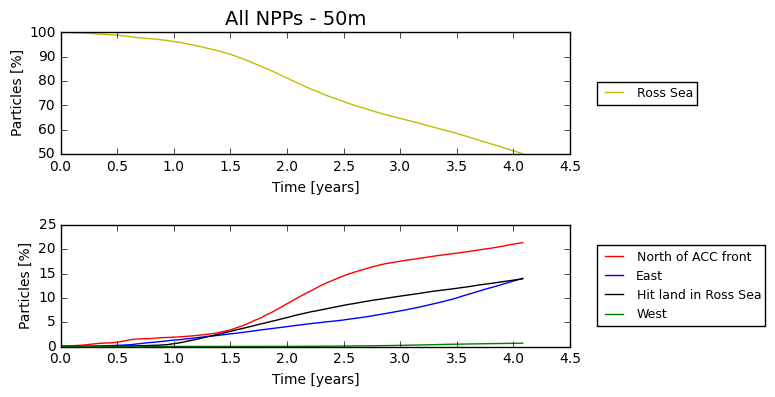

In [94]:
plot_1NPP(npts = Sum_Zones['Z1'][0], title = 'All NPPs - 50m', dictionary_of_zones=Sum_Zones)

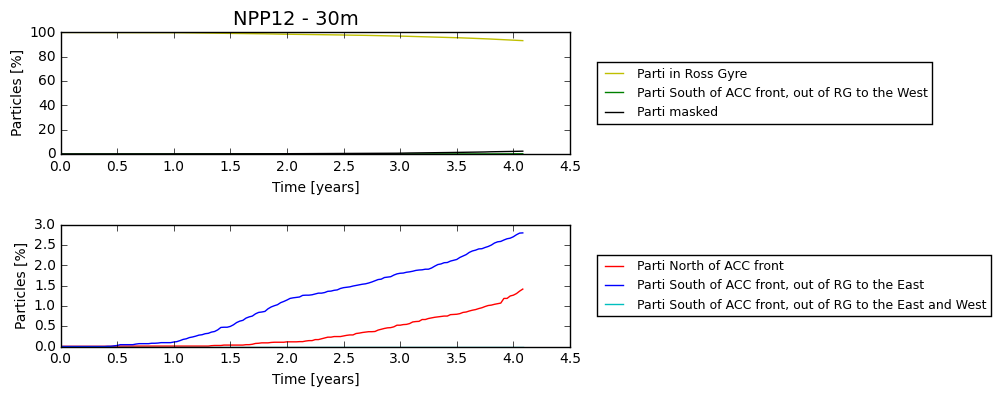

In [29]:
plot_1NPP(npts = sum_zones['Z1'][0], title = 'NPP' + NPP + ' - 50m', dictionary_of_zones=sum_zones)

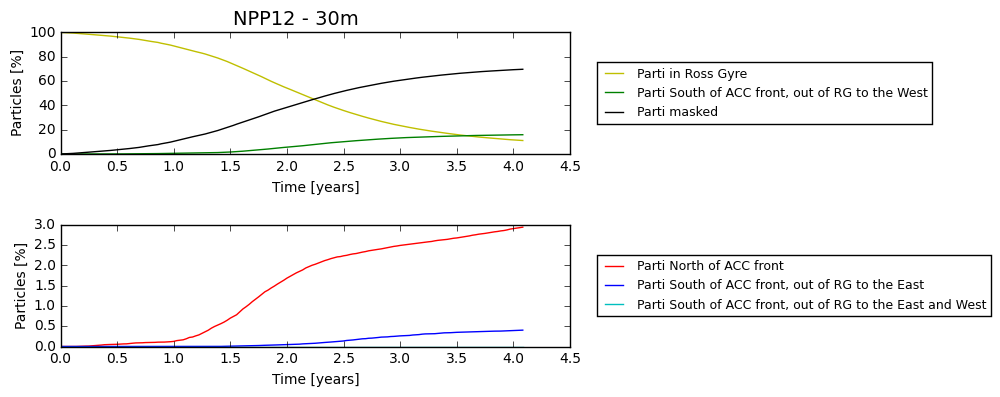

In [17]:
plot_1NPP(npts = Sum_Zones['Z1'][0], title = 'NPP' + NPP + ' - 50m', dictionary_of_zones=Sum_Zones)

***

## Make figure with several NPP

In [ ]:
fig = plt.figure(figsize=(14,14))
i = 1
for NPP in NPPs:
    evo_zone1 = pickle_load(NPP + '_evo_zone1', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone2 = pickle_load(NPP + '_evo_zone2', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone3 = pickle_load(NPP + '_evo_zone3', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone4 = pickle_load(NPP + '_evo_zone4', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    evo_zone5 = pickle_load(NPP + '_evo_zone5', '/data/ebent/Particle_analysis/' + folder, verbose=False)
    total = np.ones(evo_zone2.shape[0])*10000
    total = total-evo_zone2-evo_zone3-evo_zone4-evo_zone5
    
    plt.subplot(4,3,i)
    plot1(NPP)
    i+=1
fig.tight_layout

***

# Test cells

In [38]:
Ind_parti_north = pickle_load('Ind_parti_north', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Ind_parti_north.npy')


In [140]:
NPP = 'NPP12'
DEP = pickle_load(NPP + '_DEP', Path)
LAT = pickle_load(NPP + '_LAT', Path)
LON = pickle_load(NPP + '_LON', Path)

zround = pickle_load(NPP + '_zround', Path)
yround = pickle_load(NPP + '_yround', Path)
xround = pickle_load(NPP + '_xround', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_DEP.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_LAT.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_LON.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_zround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_yround.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/NPP12_xround.npy')


In [ ]:
N = '02'
i = 137
tmp = np.squeeze(np.array(np.ma.where(southern_front[yround[:,Ind_parti_north[N][i]], xround[:,Ind_parti_north[N][i]]]==0)))

# Actual code

In [14]:
Path = '/data/ebent/Octopus/output/50m_line_RG/'

In [17]:
# Loop to save the p indexes of particles that go north thanks to function count_in_zones

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

Ind_parti_north = {}

for NPP in npp:
    print 'NPP', NPP
    zround = pickle_load('NPP' + NPP + '_zround', Path, verbose=False)
    yround = pickle_load('NPP' + NPP + '_yround', Path, verbose=False)
    xround = pickle_load('NPP' + NPP + '_xround', Path, verbose=False)

    in_RG, to_east, to_north, to_west, to_west_east = count_in_zones(NPP, xround, yround, zround)

    Ind_parti_north[NPP] = to_north
    
pickle_save('Ind_parti_north', Path, Ind_parti_north)

NPP 01

NPP01 :

Particles that stay in the Ross Gyre : 5786
Particles that go North : 2580
Particles that go West : 102
Particles that go East : 1532
Particles that go East then West : 0
Particles that are masked : 0
Total number of particles not dead : 10000
NPP 02

NPP02 :

Particles that stay in the Ross Gyre : 6015
Particles that go North : 2496
Particles that go West : 96
Particles that go East : 1393
Particles that go East then West : 0
Particles that are masked : 0
Total number of particles not dead : 10000
NPP 03

NPP03 :

Particles that stay in the Ross Gyre : 5985
Particles that go North : 2461
Particles that go West : 96
Particles that go East : 1458
Particles that go East then West : 0
Particles that are masked : 0
Total number of particles not dead : 10000
NPP 04

NPP04 :

Particles that stay in the Ross Gyre : 6149
Particles that go North : 2359
Particles that go West : 99
Particles that go East : 1393
Particles that go East then West : 0
Particles that are masked : 0
To

In [18]:
# Loop to save the t indexes of particles that go north thanks to index of p we selected above, use of southern_front

npp = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
T_step_parti_north = {}

for NPP in npp:
    zround = pickle_load('NPP' + NPP + '_zround', Path, verbose=False)
    yround = pickle_load('NPP' + NPP + '_yround', Path, verbose=False)
    xround = pickle_load('NPP' + NPP + '_xround', Path, verbose=False)
    print 'NPP', NPP
    t_to_north = []
    
    for i in range(len(Ind_parti_north[NPP])):
        #print i
        tmp = np.squeeze(np.array(np.ma.where(southern_front[yround[:,Ind_parti_north[NPP][i]], xround[:,Ind_parti_north[NPP][i]]]==0)))
        if tmp.size == 1:
            t_to_north.append(np.int_(tmp))
        else:
            t_to_north.append(tmp[0])
                                  
    T_step_parti_north[NPP] = t_to_north
    #print T_step_parti_north[NPP]

pickle_save('T_step_parti_north', Path, T_step_parti_north)

NPP 01
NPP 02
NPP 03
NPP 04
NPP 05
NPP 06
NPP 07
NPP 08
NPP 09
NPP 10
NPP 11
NPP 12
('saved at : ', '/data/ebent/Octopus/output/50m_line_RG/T_step_parti_north.npy')


In [19]:
# Check if lists containing indexes p and t have same length = nb of parti that go north
for NPP in npp:
    print len(T_step_parti_north[NPP]), len(Ind_parti_north[NPP])

2580 2580
2496 2496
2461 2461
2359 2359
2356 2356
2323 2323
2093 2093
2094 2094
1891 1891
1872 1872
1812 1812
1814 1814


In [38]:
T_step_parti_north = pickle_load('T_step_parti_north', Path)
Ind_parti_north = pickle_load('Ind_parti_north', Path)

('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/T_step_parti_north.npy')
('loaded from : ', '/data/ebent/Octopus/output/255m_line_RG/Ind_parti_north.npy')


In [21]:
import itertools

In [22]:
# Make one list with all depths of crossing for all NPPs

DEP_cross = []
LON_cross = []
TIME_cross = []
for NPP in npp:
    #print 'NPP', NPP
    DEP = pickle_load('NPP' + NPP + '_DEP', Path, verbose=False)
    DEP_cross.append(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    
    LON = pickle_load('NPP' + NPP + '_LON', Path, verbose=False)
    LON_cross.append(LON[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    
    TIME_cross.append(T_step_parti_north[NPP])
    
DEP_cross = list(itertools.chain(*DEP_cross))
LON_cross = list(itertools.chain(*LON_cross))
TIME_cross = list(itertools.chain(*TIME_cross))

In [23]:
for NPP in npp:
    DEP = pickle_load('NPP' + NPP + '_DEP', Path, verbose=False)
    LON = pickle_load('NPP' + NPP + '_LON', Path, verbose=False)

    print 'Mean longitude of NPP', NPP, ':', np.mean(LON[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    print 'Mean depth of NPP', NPP, ':', np.mean(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    print ''
    #print 'Max of NPP', NPP, ':', np.max(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]])
    #plt.figure()
    #plt.hist(DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]], bins=15)#, weights=DEP[T_step_parti_north[NPP],Ind_parti_north[NPP]]*100/len(T_step_parti_north[NPP])) 

Mean longitude of NPP 01 : 220.466763566
Mean depth of NPP 01 : 11.021693314

Mean longitude of NPP 02 : 218.662910657
Mean depth of NPP 02 : 9.34168575972

Mean longitude of NPP 03 : 218.244184275
Mean depth of NPP 03 : 9.22584981969

Mean longitude of NPP 04 : 218.740885969
Mean depth of NPP 04 : 9.56333622563

Mean longitude of NPP 05 : 218.220155985
Mean depth of NPP 05 : 10.1114839771

Mean longitude of NPP 06 : 218.563791433
Mean depth of NPP 06 : 9.53421289819

Mean longitude of NPP 07 : 218.653159341
Mean depth of NPP 07 : 9.85525412088

Mean longitude of NPP 08 : 218.369687202
Mean depth of NPP 08 : 10.8092112136

Mean longitude of NPP 09 : 218.354409043
Mean depth of NPP 09 : 10.1292987341

Mean longitude of NPP 10 : 217.000567575
Mean depth of NPP 10 : 9.55609183026

Mean longitude of NPP 11 : 216.26638383
Mean depth of NPP 11 : 10.5289778215

Mean longitude of NPP 12 : 216.279286108
Mean depth of NPP 12 : 9.70431797822



<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x2984190>>

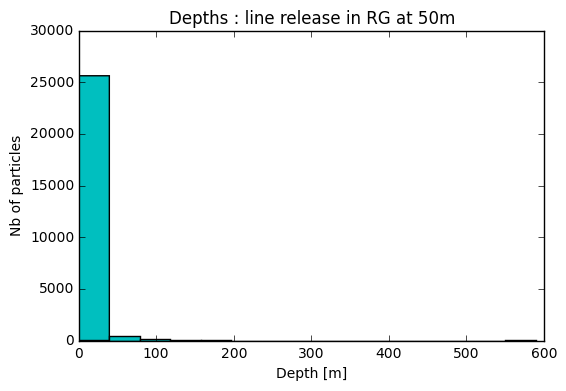

In [24]:
fig = plt.figure()
plt.hist(DEP_cross, bins=15, color='c')
plt.title('Depths : line release in RG at 50m', )
plt.xlabel('Depth [m]')
plt.ylabel('Nb of particles')
fig.tight_layout

<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x2968f50>>

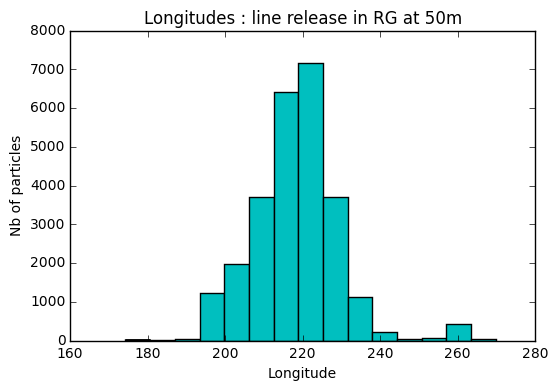

In [25]:
fig = plt.figure()
plt.hist(LON_cross, bins=15, color='c')
plt.title('Longitudes : line release in RG at 50m', )
plt.xlabel('Longitude')
plt.ylabel('Nb of particles')
fig.tight_layout

<bound method Figure.tight_layout of <matplotlib.figure.Figure object at 0x1dff02d0>>

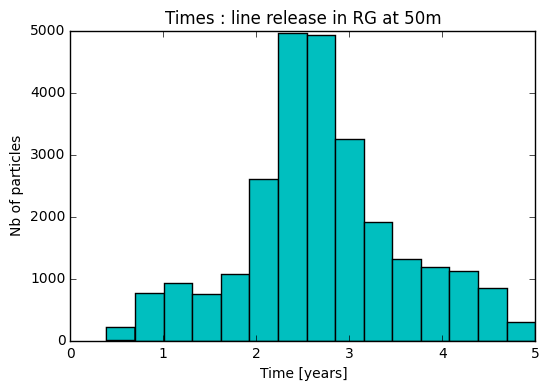

In [26]:
fig = plt.figure()

TIME_cross_yr = np.array(TIME_cross, dtype=np.float64)*10/360 
plt.hist(TIME_cross_yr, bins=15, color='c')
plt.title('Times : line release in RG at 50m', )
plt.xlabel('Time [years]')
plt.ylabel('Nb of particles')
fig.tight_layout

# Months of crossing

## This makes a list of 5yrs filled with the info on which month it is

In [39]:
MAY = []
JUL = []
AUG = []
OCT = []
DEC = []
JAN = []
MAR = []

for i in range(1,32):
    MAY.append('MAY')
    JUL.append('JUL')
    AUG.append('AUG')
    OCT.append('OCT')
    DEC.append('DEC')
    JAN.append('JAN')
    MAR.append('MAR')

In [40]:
JUN = []
SEP = []
NOV = []

for i in range(1,31):
    JUN.append('JUN')
    SEP.append('SEP')
    NOV.append('NOV')

In [41]:
FEB = []
for i in range(1,29):
    FEB.append('FEB')

In [42]:
beg_APR = []
end_APR = []

for i in range(1,6):
    beg_APR.append('APR')
    
for i in range(6,31):
    end_APR.append('APR')

In [43]:
Year = []
Year = [beg_APR, MAY, JUN, JUL, AUG, SEP, OCT, NOV, DEC, JAN, FEB, MAR, end_APR]

In [44]:
Year_1_list = list(itertools.chain(*Year))

In [45]:
Five_Years = []
for i in range(5):
    Five_Years.append(Year_1_list)

In [46]:
Five_Years_1_list = list(itertools.chain(*Five_Years))

In [47]:
len(Five_Years_1_list)

1825

## Searchs the month that correspond to the time in index

In [48]:
analysis = []
for i in range(len(TIME_cross)):
    analysis.append(Five_Years_1_list[np.array(TIME_cross[i])*10])

In [50]:
y = ['APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'JAN', 'FEB', 'MAR']

for y in y:
    print y 
    print np.squeeze(np.array(np.where(np.array(analysis) == y))).size
    print ''

APR
1991

MAY
2308

JUN
2071

JUL
2203

AUG
2294

SEP
2225

OCT
2409

NOV
2243

DEC
2155

JAN
2652

FEV
1571

MAR
2029



In [51]:
from collections import Counter

num = Counter(analysis)

In [52]:
x = list(num.values())
y = list(num.keys())

In [53]:
for i in range(12):
    print i, y[i]

0 FEV
1 MAR
2 AUG
3 SEP
4 MAY
5 JUN
6 JUL
7 JAN
8 APR
9 NOV
10 DEC
11 OCT


In [54]:
Y = list(y)

In [55]:
Y[0] = y[7]
Y[1] = y[0]
Y[2] = y[1]
Y[3] = y[8]
Y[4] = y[4]
Y[5] = y[5]
Y[6] = y[6]
Y[7] = y[2]
Y[8] = y[3]
Y[9] = y[11]
Y[10] = y[9]
Y[11] = y[10]

In [56]:
for i in range(12):
    print i, Y[i]

0 JAN
1 FEV
2 MAR
3 APR
4 MAY
5 JUN
6 JUL
7 AUG
8 SEP
9 OCT
10 NOV
11 DEC


In [58]:
X = list(x)

In [59]:
X[0] = x[7]
X[1] = x[0]
X[2] = x[1]
X[3] = x[8]
X[4] = x[4]
X[5] = x[5]
X[6] = x[6]
X[7] = x[2]
X[8] = x[3]
X[9] = x[11]
X[10] = x[9]
X[11] = x[10]

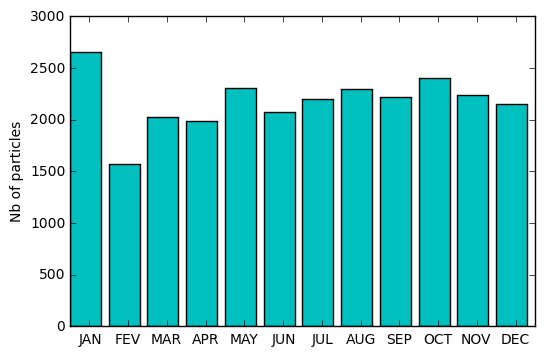

In [72]:
x_coordinates = np.arange(len(num.keys()))
plt.bar(x_coordinates, X, color='c')
#plt.xticks(Y)
x_coordinates = np.arange(len(num.keys()))+0.5
plt.xticks(x_coordinates, Y)
plt.ylabel('Nb of particles')